In [14]:
import os
import sys

import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.graph_objects as go
from itertools import permutations
import optax
import chex
from tqdm import tqdm


# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)


def radius_mae(arr1, arr2):
    """
    Compute the minimum average of the absolute differences between two arrays
    by trying all possible permutations of the second array.
    
    Parameters:
    arr1 (numpy.ndarray): First 1D numpy array
    arr2 (numpy.ndarray): Second 1D numpy array of the same length as arr1
    
    Returns:
    float: Minimum average absolute difference
    tuple: The permutation of arr2 that gives the minimum difference
    """

    arr1_norms = jnp.linalg.norm(arr1, axis=1)
    arr2_norms = jnp.linalg.norm(arr2, axis=1)

    if len(arr1_norms) != len(arr2_norms):
        return jnp.nan
    
    if len(arr1) == 0:
        return 0, []
    
    min_avg = float('inf')
    best_perm = None
    
    # Generate all permutations of arr2
    for perm in permutations(arr2_norms):
        perm_arr = jnp.array(perm)
        # Calculate absolute differences
        abs_diff = jnp.abs(arr1_norms - perm_arr)
        # Calculate mean of absolute differences
        avg_diff = jnp.mean(abs_diff)
        
        # Update minimum if current permutation gives better result
        if avg_diff < min_avg:
            min_avg = avg_diff
            best_perm = perm
    
    return float(min_avg)


def invert(true_spectrum, spectrum_function, lmax, mask_index=None, initial_points=None, n_points=20, learning_rate=1e-2, 
                     seed=0, num_iterations=10000, patience=1000):
    """
    Inverts either the power spectrum or bispectrum to a signal with adaptive learning rate.
    Returns the final signal and history of points saved every 100 iterations.
    
    Args:
        true_spectrum: Target spectrum to match
        spectrum_function: Either powerspectrum or bispectrum
        lmax: Maximum degree for spherical harmonics
        mask_index: Index of the bispectrum component to mask in loss calculation (None to use all components)
        initial_points: Initial point locations (None for random initialization)
        learning_rate: Initial learning rate
        seed: Random seed for initialization
        num_iterations: Maximum number of iterations
        
    Returns:
        tuple: (best_points, points_history, losses_history)
            - best_points: Points that achieved the lowest loss
            - points_history: Dictionary with iteration numbers as keys and points at those iterations as values
            - losses_history: Dictionary with iteration numbers as keys and loss values at those iterations
    """
    def loss(
        params: optax.Params, true_spectrum: chex.Array
    ) -> chex.Array:
        """Computes the loss corresponding to the current parameters."""
        predicted_signal = sum_of_diracs(params["points"], lmax)
        pred_spectrum = spectrum_function(predicted_signal)
        
        if mask_index is not None:
            # Create a mask that is True for all indices except the one to be masked
            mask = jnp.ones_like(true_spectrum, dtype=bool)
            mask = mask.at[mask_index].set(False)
            
            # Apply the mask to both true and predicted spectra
            masked_true = true_spectrum * mask
            masked_pred = pred_spectrum * mask
            
            # Compute L1 loss only on unmasked elements
            return jnp.abs(masked_true - masked_pred).mean()
            # return optax.l2_loss(masked_true, masked_pred).mean()
        else:
            # Original behavior when no masking is requested
            return jnp.abs(true_spectrum - pred_spectrum).mean()
            # return optax.l2_loss(true_spectrum, pred_spectrum).mean()

    def fit(
        params: optax.Params,
        learning_rate: float,
        true_spectrum: chex.Array,
        max_iter: int = num_iterations,
    ):
        # Create optimizer with fixed learning rate
        optimizer = optax.adam(learning_rate=learning_rate)        
        opt_state = optimizer.init(params)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}
        
        # Pure function to update parameters - JIT compatible
        @jax.jit
        def step(params, opt_state, true_spectrum, step_idx):
            loss_value, grads = jax.value_and_grad(loss)(
                params, true_spectrum
            )
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value
        
        for iter in tqdm(range(max_iter)):
            # Pass iteration count to the step function
            params, opt_state, loss_value = step(
                params, opt_state, true_spectrum, iter
            )
            
            # Save points every iterations
            if iter % 100 == 0:
                # We need to convert JAX arrays to numpy arrays for the history
                points_history[iter] = jax.device_get(params["points"])
                losses_history[iter] = jax.device_get(loss_value)
                # print(f"step {iter}, loss: {loss_value}")
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                # print(f"Stopping early at step {iter}: no improvement for {patience} iterations")
                # Save the final points before breaking
                if iter % 100 != 0:  # Only if we haven't just saved them
                    points_history[iter] = jax.device_get(params["points"])
                    losses_history[iter] = jax.device_get(loss_value)
                break

        # Return the best parameters found during optimization
        # print(f"Final best loss: {min_loss}")
        return best_params, points_history, losses_history
    
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Create optimizer with fixed learning rate
    final_params, points_history, losses_history = fit(init_params, learning_rate, true_spectrum)
    
    # Return both the best points and the history of points
    return final_params["points"], points_history, losses_history



In [18]:
def invert_with_lbfgs(true_spectrum, spectrum_function, lmax, mask_index=None, initial_points=None, n_points=20, 
                     learning_rate=None, seed=0, num_iterations=100000, patience=5000, memory_size=10, 
                     scale_init_precond=True):
    """
    Inverts either the power spectrum or bispectrum to a signal using L-BFGS optimizer.
    Returns the final signal and history of points saved every 100 iterations.
    
    Args:
        true_spectrum: Target spectrum to match
        spectrum_function: Either powerspectrum or bispectrum
        lmax: Maximum degree for spherical harmonics
        mask_index: Index of the bispectrum component to mask in loss calculation (None to use all components)
        initial_points: Initial point locations (None for random initialization)
        n_points: Number of points to initialize if initial_points is None
        learning_rate: Learning rate (None to let linesearch handle it automatically)
        seed: Random seed for initialization
        num_iterations: Maximum number of iterations
        patience: Early stopping patience
        memory_size: Number of previous iterations to store for L-BFGS
        scale_init_precond: Whether to use scaled identity as initial preconditioner
        
    Returns:
        tuple: (best_points, points_history, losses_history)
            - best_points: Points that achieved the lowest loss
            - points_history: Dictionary with iteration numbers as keys and points at those iterations as values
            - losses_history: Dictionary with iteration numbers as keys and loss values at those iterations
    """
    def loss_fn(params):
        """Computes the loss corresponding to the current parameters."""
        predicted_signal = sum_of_diracs(params["points"], lmax)
        pred_spectrum = spectrum_function(predicted_signal)
        
        if mask_index is not None:
            # Create a mask that is True for all indices except the one to be masked
            mask = jnp.ones_like(true_spectrum, dtype=bool)
            mask = mask.at[mask_index].set(False)
            
            # Apply the mask to both true and predicted spectra
            masked_true = true_spectrum * mask
            masked_pred = pred_spectrum * mask
            
            # Compute L1 loss only on unmasked elements
            return jnp.abs(masked_true - masked_pred).mean()
        else:
            # Original behavior when no masking is requested
            return jnp.abs(true_spectrum - pred_spectrum).mean()
    
    def fit(
        params: optax.Params,
        max_iter: int = num_iterations,
    ):
        # Configure L-BFGS with zoom linesearch (default)
        optimizer = optax.lbfgs(
            learning_rate=learning_rate,
            memory_size=memory_size,
            scale_init_precond=scale_init_precond,
        )
        
        opt_state = optimizer.init(params)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}

        for iter in tqdm(range(max_iter)):
            # L-BFGS requires current value and gradient for linesearch
            value = loss_fn(params)
            grad = jax.grad(loss_fn)(params)
            
            # Define the value_fn for linesearch (required for linesearch to evaluate points)
            def value_fn(p):
                return loss_fn(p)
            
            # Update parameters with L-BFGS, providing required arguments for linesearch
            updates, opt_state = optimizer.update(
                grad, 
                opt_state, 
                params, 
                value=value,        # Current loss value
                grad=grad,          # Current gradient
                value_fn=value_fn   # Function to compute loss at new points
            )
            
            params = optax.apply_updates(params, updates)
            loss_value = value  # Store current loss
            
            # Save points and loss for every iteration
            points_history[iter] = jax.device_get(params["points"])
            losses_history[iter] = jax.device_get(loss_value)
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                break

        # Return the best parameters found during optimization
        return best_params, points_history, losses_history
    
    # Initialize points if not provided
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Run optimization with L-BFGS
    final_params, points_history, losses_history = fit(init_params)
    
    # Return both the best points and the history of points
    return final_params["points"], points_history, losses_history

In [7]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [8]:
index = 0

true_geometry = jnp.array(local_envs[index])
print("Number of points:", len(true_geometry))

Number of points: 4


Number of points: 4


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


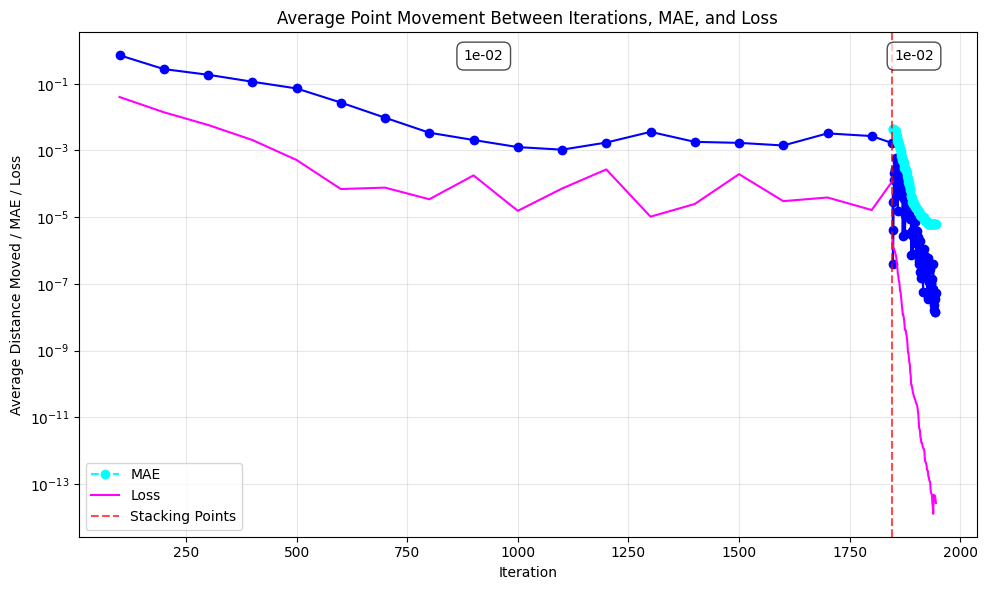

In [26]:
index = 0
lmax = 5

true_geometry = jnp.array(local_envs[index])
print("Number of points:", len(true_geometry))
true_signal = sum_of_diracs(true_geometry, lmax)
true_bispectrum = bispectrum(true_signal)

# Define a list of learning rates to use in sequence
learning_rates = [1e-2, 1e-2]


# Initialize variables to store results
all_points_history = []
all_losses_history = []
max_iters = []
iterations_list = []
avg_distances_list = []
mae_values_list = []
loss_values_list = []

# Run the initial inversion
predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=10, learning_rate=learning_rates[0], num_iterations=100000, patience=1000)
all_points_history.append(points_history)
all_losses_history.append(losses_history)
max_iters.append(max(points_history.keys()))

# Stack points after first inversion
stacked_points = stack_points(predicted_points)
current_points = stacked_points

# Track the best points and lowest loss
best_loss = float('inf')
best_predicted_geometry = None

# Check if the initial result is the best so far
min_loss_key = min(losses_history, key=losses_history.get)
if losses_history[min_loss_key] < best_loss:
    best_loss = losses_history[min_loss_key]
    best_predicted_geometry = points_history[min_loss_key]

# Run subsequent inversions with different learning rates
for i in range(1, len(learning_rates)):
    predicted_points, points_history, losses_history = invert_with_lbfgs(true_bispectrum, bispectrum, lmax, initial_points=current_points, learning_rate=learning_rates[i], num_iterations=100, patience=10)
    all_points_history.append(points_history)
    all_losses_history.append(losses_history)
    max_iters.append(max(points_history.keys()))
    current_points = predicted_points
    
    # Check if this phase produced a better result
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_predicted_geometry = points_history[min_loss_key]

# Process each phase's history
for phase, points_history in enumerate(all_points_history):
    keys = sorted(points_history.keys())
    
    # Calculate average distance moved between consecutive iterations
    avg_distances = []
    for i in range(len(keys) - 1):
        current_points = points_history[keys[i]]
        next_points = points_history[keys[i+1]]
        
        # Calculate Euclidean distance for each point between iterations
        distances = jnp.linalg.norm(next_points - current_points, axis=1)
        
        # Calculate the average distance moved across all points
        avg_distance = jnp.mean(distances)
        avg_distances.append(avg_distance)
    
    # Calculate iteration offsets for continuous plotting
    offset = sum(max_iters[:phase]) if phase > 0 else 0
    iterations = [keys[i+1] + offset for i in range(len(keys) - 1)]
    
    # Calculate MAE for each iteration
    mae_values = []
    for i in range(len(keys) - 1):
        current_points = points_history[keys[i+1]]
        mae = radius_mae(current_points, true_geometry)
        mae_values.append(mae)
    
    # Extract loss values
    loss_values = [all_losses_history[phase][keys[i+1]] for i in range(len(keys) - 1)]
    
    # Store processed data
    iterations_list.append(iterations)
    avg_distances_list.append(avg_distances)
    mae_values_list.append(mae_values)
    loss_values_list.append(loss_values)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot average distance moved for all phases with the same color
for phase in range(len(all_points_history)):
    plt.plot(iterations_list[phase], avg_distances_list[phase], marker='o', linestyle='-', color='blue')

# Plot MAE values with a single legend entry
for phase in range(len(all_points_history)):
    label = 'MAE' if phase == 0 else None
    plt.plot(iterations_list[phase], mae_values_list[phase], marker='o', linestyle='--', color='cyan', label=label)

# Plot loss values with a single legend entry
for phase in range(len(all_points_history)):
    label = 'Loss' if phase == 0 else None
    plt.plot(iterations_list[phase], loss_values_list[phase], linestyle='-', color='magenta', label=label)

# Add vertical lines to separate the inversion phases
cumulative_iters = 0
for phase in range(len(max_iters) - 1):
    cumulative_iters += max_iters[phase]
    label = 'Stacking Points' if phase == 0 else None
    plt.axvline(x=cumulative_iters, color='red' if phase == 0 else 'gray', 
                linestyle='--', alpha=0.7, label=label)

# Annotate each phase with its learning rate
cumulative_iters = 0
y_pos = plt.ylim()[1] * 0.9  # Position annotations near the top
for phase, lr in enumerate(learning_rates):
    # Calculate the midpoint of this phase for annotation placement
    if phase == 0:
        midpoint = max_iters[phase] / 2
    else:
        midpoint = cumulative_iters + max_iters[phase] / 2
    
    # Add annotation with the learning rate
    plt.annotate(f'{lr:.0e}', xy=(midpoint, y_pos), 
                 xytext=(0, 0), textcoords='offset points',
                 ha='center', va='center', 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
    
    # Update cumulative iterations for next phase
    cumulative_iters += max_iters[phase]

plt.xlabel('Iteration')
plt.ylabel('Average Distance Moved / MAE / Loss')
plt.title('Average Point Movement Between Iterations, MAE, and Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale often helps visualize convergence
plt.legend()
plt.tight_layout()
plt.show()

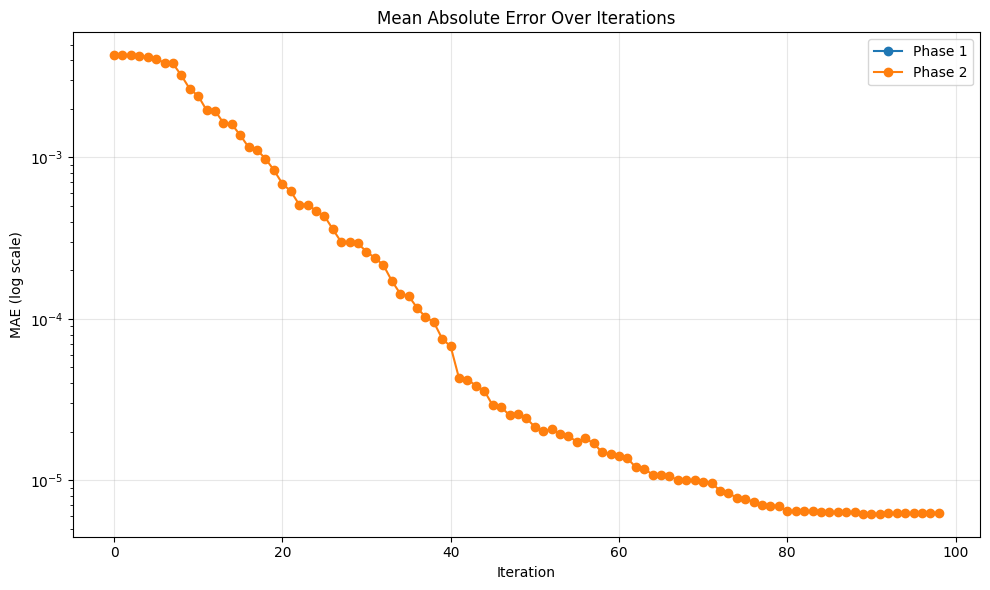

In [27]:
# Filter out NaN values from each list in mae_values_list
filtered_mae_values = []
for phase_values in mae_values_list:
    # Filter out NaN values
    filtered_values = [val for val in phase_values if not np.isnan(val)]
    filtered_mae_values.append(filtered_values)

# Plot the filtered MAE values with log scale
plt.figure(figsize=(10, 6))
for i, values in enumerate(filtered_mae_values):
    # Create corresponding x values (iterations) for the filtered data
    iterations = list(range(len(values)))
    plt.plot(iterations, values, marker='o', linestyle='-', label=f'Phase {i+1}')

plt.yscale('log')  # Set log scale for y-axis
plt.xlabel('Iteration')
plt.ylabel('MAE (log scale)')
plt.title('Mean Absolute Error Over Iterations')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Processing environment 1/5


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Processing environment 2/5


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Processing environment 3/5


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Processing environment 4/5


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Processing environment 5/5


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


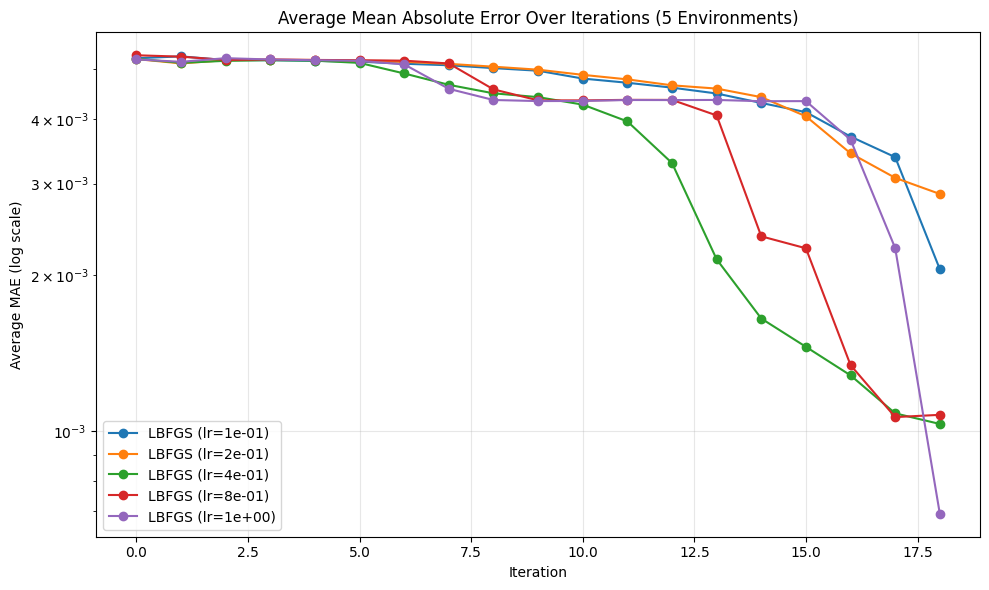

In [31]:
# Use multiple environments for more robust evaluation
num_envs = 5
lmax = 5

# Initialize variables to store results across all environments
mae_values_list_per_env = []

# Define a list of learning rates for LBFGS to compare
lbfgs_learning_rates = [1e-1, 2e-1, 4e-1, 8e-1, 1e-0]
initial_lr = 1e-2

# Process each environment
for env_idx in range(num_envs):
    print(f"Processing environment {env_idx+1}/{num_envs}")
    
    true_geometry = jnp.array(local_envs[env_idx])
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    
    # Initialize variables for this environment
    all_points_history = []
    all_losses_history = []
    mae_values_list = []
    
    # Run the initial inversion with fixed learning rate
    predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=10, learning_rate=initial_lr, num_iterations=100000, patience=1000)
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    initial_points = stacked_points
    
    # Run LBFGS inversions with different learning rates
    for lr in lbfgs_learning_rates:
        predicted_points, points_history, losses_history = invert_with_lbfgs(true_bispectrum, bispectrum, lmax, initial_points=initial_points, learning_rate=lr, num_iterations=20, patience=10)
        
        # Calculate MAE for each iteration
        keys = sorted(points_history.keys())
        mae_values = []
        for i in range(len(keys) - 1):
            current_points = points_history[keys[i+1]]
            mae = radius_mae(current_points, true_geometry)
            mae_values.append(mae)
        
        mae_values_list.append(mae_values)
    
    # Store all data for this environment
    mae_values_list_per_env.append(mae_values_list)

# Average MAE values across all environments for each LBFGS learning rate
avg_mae_values_by_lr = []

# Process each learning rate
for lr_idx in range(len(lbfgs_learning_rates)):
    lr_maes = []
    for env_idx in range(num_envs):
        # Get MAE values for this learning rate
        mae_values = mae_values_list_per_env[env_idx][lr_idx]
        lr_maes.append(mae_values)
    
    # Find the minimum length to truncate all arrays to the same length
    min_length = min(len(maes) for maes in lr_maes)
    # Truncate and average
    avg_lr_maes = []
    for i in range(min_length):
        avg_mae = np.mean([maes[i] for maes in lr_maes])
        avg_lr_maes.append(avg_mae)
    avg_mae_values_by_lr.append(avg_lr_maes)

# Plot the averaged MAE values with log scale
plt.figure(figsize=(10, 6))

# Plot LBFGS with different learning rates
for i, lr in enumerate(lbfgs_learning_rates):
    iterations = list(range(len(avg_mae_values_by_lr[i])))
    plt.plot(iterations, avg_mae_values_by_lr[i], marker='o', linestyle='-', label=f'LBFGS (lr={lr:.0e})')

plt.yscale('log')  # Set log scale for y-axis
plt.xlabel('Iteration')
plt.ylabel('Average MAE (log scale)')
plt.title('Average Mean Absolute Error Over Iterations (5 Environments)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Processing environment 1/10


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Processing environment 2/10


100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


Processing environment 3/10


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Processing environment 4/10


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Processing environment 5/10


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Processing environment 6/10


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Processing environment 7/10


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Processing environment 8/10


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Processing environment 9/10


 70%|███████   | 14/20 [00:10<00:04,  1.39it/s]


Processing environment 10/10


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


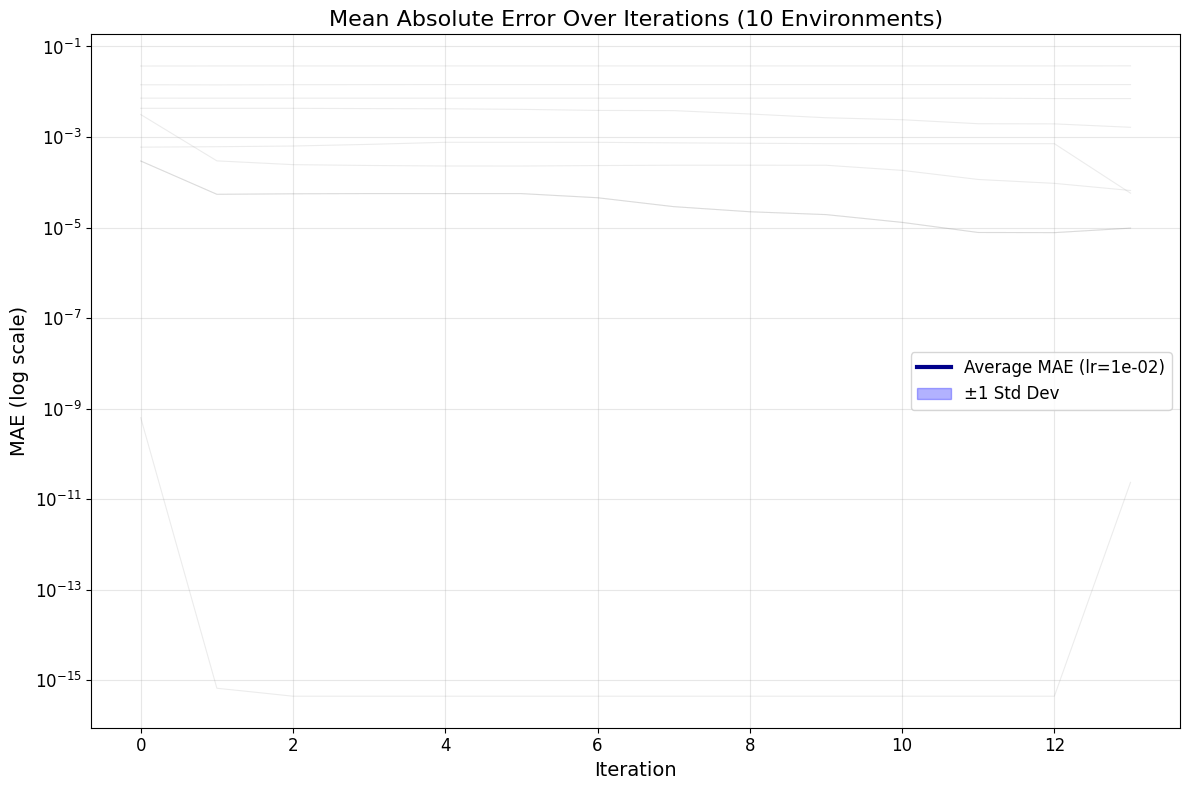

In [ ]:
# Use multiple environments for more robust evaluation
num_envs = 10
lmax = 5

# Initialize variables to store results across all environments
mae_values_list_per_env = []

# Define the learning rate for LBFGS
lbfgs_learning_rate = 1e-2
initial_lr = 1e-2

# Process each environment
for env_idx in range(num_envs):
    print(f"Processing environment {env_idx+1}/{num_envs}")
    
    true_geometry = jnp.array(local_envs[env_idx])
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    
    # Run the initial inversion with fixed learning rate
    predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=10, learning_rate=initial_lr, num_iterations=100000, patience=1000)
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    initial_points = stacked_points
    
    # Run LBFGS inversion
    predicted_points, points_history, losses_history = invert_with_lbfgs(true_bispectrum, bispectrum, lmax, initial_points=initial_points, learning_rate=lbfgs_learning_rate, num_iterations=20, patience=10)
    
    # Calculate MAE for each iteration
    keys = sorted(points_history.keys())
    mae_values = []
    for i in range(len(keys) - 1):
        current_points = points_history[keys[i+1]]
        mae = radius_mae(current_points, true_geometry)
        mae_values.append(mae)
    
    # Store MAE values for this environment
    mae_values_list_per_env.append(mae_values)

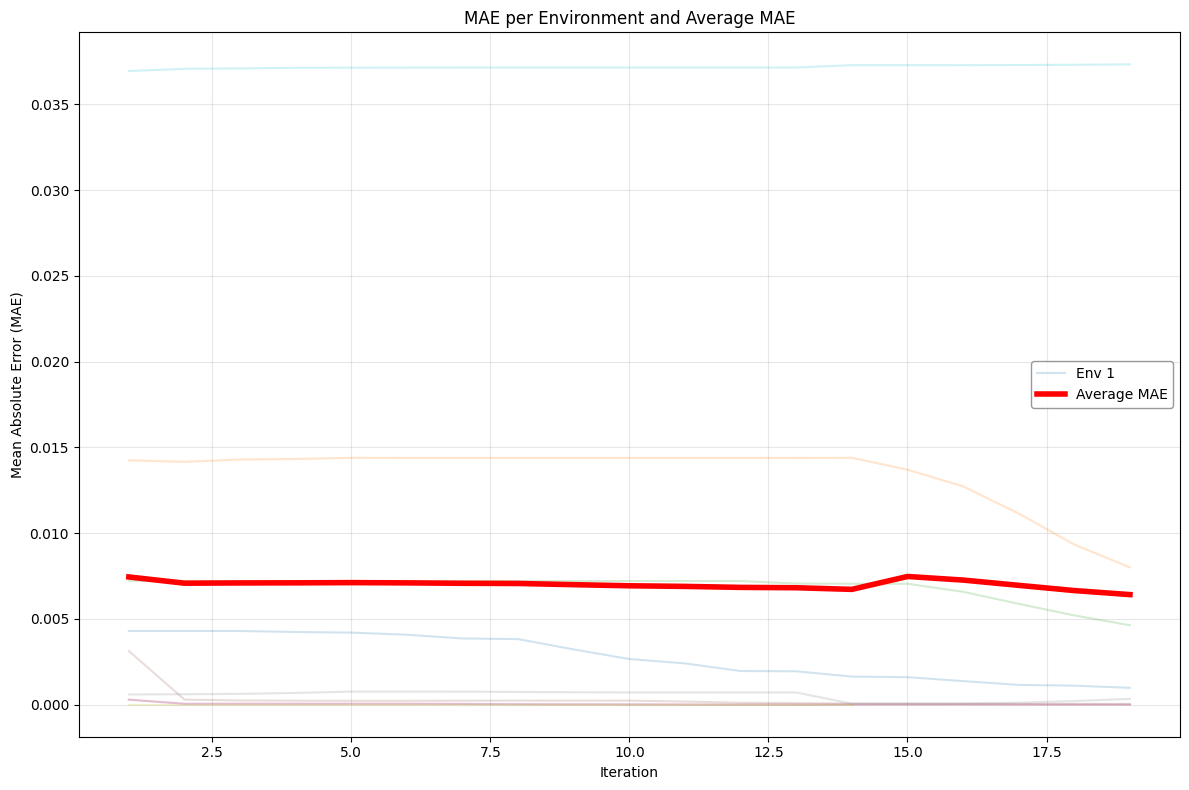

In [45]:
# Plot MAE values for each environment and the average
plt.figure(figsize=(12, 8))

# Plot individual environment MAE values with lower alpha for better visibility of average
for i, mae_values in enumerate(mae_values_list_per_env):
    plt.plot(range(1, len(mae_values) + 1), mae_values, alpha=0.2, label=f'Env {i+1}' if i == 0 else None)

# Calculate and plot the average MAE across all environments
avg_mae = []
max_length = max(len(mae) for mae in mae_values_list_per_env)
for i in range(max_length):
    valid_maes = [mae[i] for mae in mae_values_list_per_env if i < len(mae) and not jnp.isnan(mae[i])]
    if valid_maes:
        avg_mae.append(sum(valid_maes) / len(valid_maes))

# Make average line more visible
plt.plot(range(1, len(avg_mae) + 1), avg_mae, color='red', linewidth=4, label='Average MAE', zorder=10)

plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE per Environment and Average MAE')
plt.legend(frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Processing environment 1/10


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Processing environment 2/10


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Processing environment 3/10


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


Processing environment 4/10


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Processing environment 5/10


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Processing environment 6/10


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Processing environment 7/10


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Processing environment 8/10


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Processing environment 9/10


 65%|██████▌   | 13/20 [00:13<00:07,  1.06s/it]


Processing environment 10/10


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


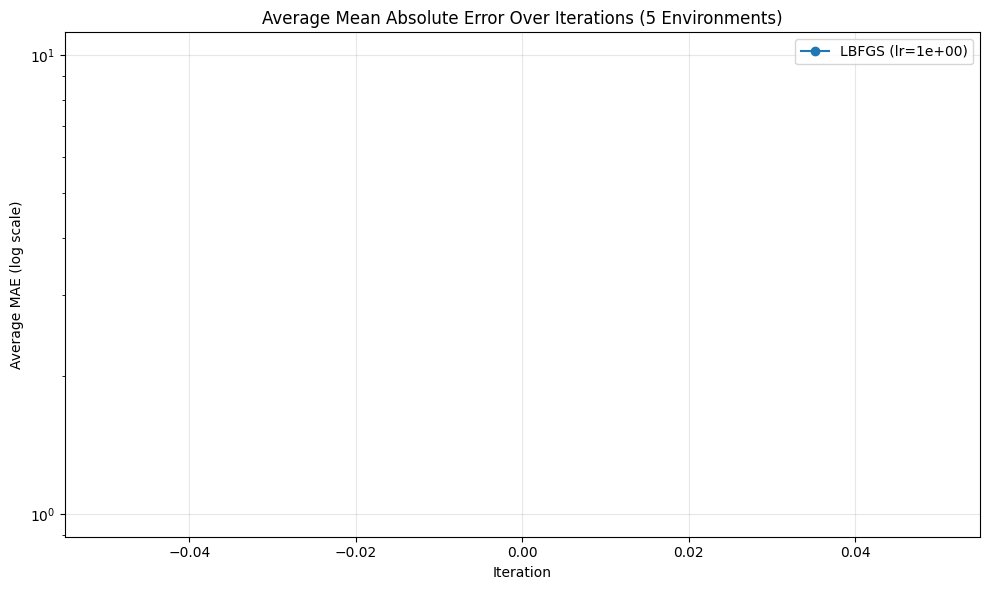

In [46]:
# Use multiple environments for more robust evaluation
num_envs = 10
lmax = 5

# Initialize variables to store results across all environments
mae_values_list_per_env = []

# Define a list of learning rates for LBFGS to compare
lbfgs_learning_rates = [1e-0]
initial_lr = 1e-2

# Process each environment
for env_idx in range(num_envs):
    print(f"Processing environment {env_idx+1}/{num_envs}")
    
    true_geometry = jnp.array(local_envs[env_idx])
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    
    # Initialize variables for this environment
    all_points_history = []
    all_losses_history = []
    mae_values_list = []
    
    # Run the initial inversion with fixed learning rate
    predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=10, learning_rate=initial_lr, num_iterations=100000, patience=1000)
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    initial_points = stacked_points
    
    # Run LBFGS inversions with different learning rates
    for lr in lbfgs_learning_rates:
        predicted_points, points_history, losses_history = invert_with_lbfgs(true_bispectrum, bispectrum, lmax, initial_points=initial_points, learning_rate=lr, num_iterations=20, patience=10)
        
        # Calculate MAE for each iteration
        keys = sorted(points_history.keys())
        mae_values = []
        for i in range(len(keys) - 1):
            current_points = points_history[keys[i+1]]
            mae = radius_mae(current_points, true_geometry)
            mae_values.append(mae)
        
        mae_values_list.append(mae_values)
    
    # Store all data for this environment
    mae_values_list_per_env.append(mae_values_list)

# Average MAE values across all environments for each LBFGS learning rate
avg_mae_values_by_lr = []

# Process each learning rate
for lr_idx in range(len(lbfgs_learning_rates)):
    lr_maes = []
    for env_idx in range(num_envs):
        # Get MAE values for this learning rate
        mae_values = mae_values_list_per_env[env_idx][lr_idx]
        lr_maes.append(mae_values)
    
    # Find the minimum length to truncate all arrays to the same length
    min_length = min(len(maes) for maes in lr_maes)
    # Truncate and average
    avg_lr_maes = []
    for i in range(min_length):
        avg_mae = np.mean([maes[i] for maes in lr_maes])
        avg_lr_maes.append(avg_mae)
    avg_mae_values_by_lr.append(avg_lr_maes)

# Plot the averaged MAE values with log scale
plt.figure(figsize=(10, 6))

# Plot LBFGS with different learning rates
for i, lr in enumerate(lbfgs_learning_rates):
    iterations = list(range(len(avg_mae_values_by_lr[i])))
    plt.plot(iterations, avg_mae_values_by_lr[i], marker='o', linestyle='-', label=f'LBFGS (lr={lr:.0e})')

plt.yscale('log')  # Set log scale for y-axis
plt.xlabel('Iteration')
plt.ylabel('Average MAE (log scale)')
plt.title('Average Mean Absolute Error Over Iterations (5 Environments)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()